In [22]:
import os
import glob
import numpy as np
from nilearn import image, masking
from scipy.stats import pearsonr
from pathlib import Path
import pandas as pd
import argparse

In [2]:
roi_dir = '/Users/xiaoqianxiao/tool/conn/rois'
networks_file = os.path.join(roi_dir, 'networks.nii')
networks_img = image.load_img(networks_file)

In [7]:
pcc_mask = image.index_img(networks_img, 3)
data = pcc_mask.get_fdata()

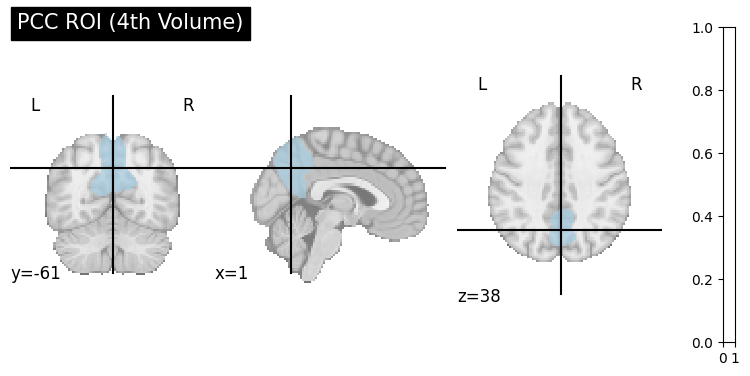

In [8]:
from nilearn import image, plotting
import matplotlib.pyplot as plt


display = plotting.plot_roi(
    pcc_mask,
    title="PCC ROI (4th Volume)",
    cut_coords=[1, -61, 38],
    cmap='Paired',
    colorbar=True,
    display_mode='ortho',
    black_bg=False
)

In [ ]:
find /project/6079231/dliang55/R01_AOCD/derivatives/fmriprep-1.4.1/sub-*/ses-baseline/func -name '*_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz'

In [9]:
import os
from templateflow.api import get as tpl_get

# Define the output directory
roi_dir = "/Users/xiaoqianxiao/tool/parcellation/standard"

# Create the output directory if it doesn't exist
os.makedirs(roi_dir, exist_ok=True)

# Download the brain mask using templateflow
tpl_file = tpl_get(
    template='MNI152NLin6Asym',
    resolution=2,
    desc='brain',
    suffix='mask',
    extension='.nii.gz'
)

# Define the output file path
output_file = os.path.join(roi_dir, "tpl-MNI152NLin6Asym_res-02_desc-brain_mask.nii.gz")

# Move or copy the file to the desired location
os.rename(tpl_file, output_file)

print(f"File downloaded and saved to {output_file}")

100%|██████████| 28.6k/28.6k [00:00<00:00, 426kB/s]

File downloaded and saved to /Users/xiaoqianxiao/tool/parcellation/standard/tpl-MNI152NLin6Asym_res-02_desc-brain_mask.nii.gz


In [10]:
from nipype.interfaces.fsl import Merge, FLIRT

In [12]:
from nipype.interfaces.fsl import Randomise
print(Randomise().output_spec().get())


from nipype.interfaces.fsl import Randomise
print(Randomise().input_spec().get())



def print_input_traits(interface_class):
    """
    Print all input traits of a Nipype interface class, with mandatory inputs listed first,
    and then extract any mutually‐exclusive input groups from the interface’s help().

    Parameters:
    - interface_class: A Nipype interface class (e.g., SpecifyModel)
    """
    import io, sys

    # 1) List all traits
    spec = interface_class().inputs
    traits = spec.traits().items()
    sorted_traits = sorted(traits, key=lambda item: not item[1].mandatory)

    print("Name                           | mandatory")
    print("-------------------------------|----------")
    for name, trait in sorted_traits:
        print(f"{name:30} | {trait.mandatory}")

    # 2) Capture help() output to find the "Mutually exclusive inputs" line
    buf = io.StringIO()
    old_stdout = sys.stdout
    sys.stdout = buf
    try:
        interface_class().help()
    finally:
        sys.stdout = old_stdout

    help_text = buf.getvalue().splitlines()
    mux_line = next((line for line in help_text if 'mutually_exclusive' in line), None)

    # 3) Parse and print mutually‐exclusive inputs if present
    if mux_line:
        # e.g. "Mutually exclusive inputs: subject_info, event_files, bids_event_file"
        _, fields = mux_line.split(':', 1)
        names = [n.strip() for n in fields.split(',')]
        print("\nMutually exclusive inputs:")
        for n in names:
            print(f"  - {n}")
    else:
        print("\nNo mutually exclusive inputs found in help().")

{'tstat_files': <undefined>, 'fstat_files': <undefined>, 't_p_files': <undefined>, 'f_p_files': <undefined>, 't_corrected_p_files': <undefined>, 'f_corrected_p_files': <undefined>}
{'in_file': <undefined>, 'base_name': 'randomise', 'design_mat': <undefined>, 'tcon': <undefined>, 'fcon': <undefined>, 'mask': <undefined>, 'x_block_labels': <undefined>, 'demean': <undefined>, 'one_sample_group_mean': <undefined>, 'show_total_perms': <undefined>, 'show_info_parallel_mode': <undefined>, 'vox_p_values': <undefined>, 'tfce': <undefined>, 'tfce2D': <undefined>, 'f_only': <undefined>, 'raw_stats_imgs': <undefined>, 'p_vec_n_dist_files': <undefined>, 'num_perm': <undefined>, 'seed': <undefined>, 'var_smooth': <undefined>, 'c_thresh': <undefined>, 'cm_thresh': <undefined>, 'f_c_thresh': <undefined>, 'f_cm_thresh': <undefined>, 'tfce_H': <undefined>, 'tfce_E': <undefined>, 'tfce_C': <undefined>, 'output_type': <undefined>, 'args': <undefined>, 'environ': {}}


In [14]:
from nipype.interfaces.fsl import FLIRT
FLIRT.help()

Wraps the executable command ``flirt``.

FSL FLIRT wrapper for coregistration

For complete details, see the `FLIRT Documentation.
<https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FLIRT>`_

To print out the command line help, use:
    fsl.FLIRT().inputs_help()

Examples
--------
>>> from nipype.interfaces import fsl
>>> from nipype.testing import example_data
>>> flt = fsl.FLIRT(bins=640, cost_func='mutualinfo')
>>> flt.inputs.in_file = 'structural.nii'
>>> flt.inputs.reference = 'mni.nii'
>>> flt.inputs.output_type = "NIFTI_GZ"
>>> flt.cmdline # doctest: +ELLIPSIS
'flirt -in structural.nii -ref mni.nii -out structural_flirt.nii.gz -omat structural_flirt.mat -bins 640 -searchcost mutualinfo'
>>> res = flt.run() #doctest: +SKIP

Inputs::

        [Mandatory]
        in_file: (a pathlike object or string representing an existing file)
                input file
                argument: ``-in %s``, position: 0
        reference: (a pathlike object or string representing an existing
              

In [20]:
def extract_pcc_roi(networks_file):
    """Extract PCC ROI from networks.nii (label 4) and resample to MNI152NLin6Asym space using FLIRT."""
    from nilearn import image
    from nipype.interfaces.fsl import FLIRT
    group_mask_file = os.path.join(roi_dir, 'tpl-MNI152NLin6Asym_res-02_desc-brain_mask.nii.gz')
    pcc_temp_file = os.path.join(work_dir, 'pcc_temp.nii.gz')
    output_file = os.path.join(work_dir, 'pcc_resampled.nii.gz')
    pcc_mask = image.index_img(networks_file, 3)
    pcc_mask.to_filename(pcc_temp_file)
    # Resample PCC ROI with FLIRT
    flirt = FLIRT()
    flirt.inputs.in_file = pcc_temp_file
    flirt.inputs.reference = group_mask_file
    flirt.inputs.out_file = output_file
    flirt.inputs.apply_isoxfm = 2
    flirt.inputs.interp = 'nearestneighbour'
    flirt.run()

In [16]:
roi_dir = '/Users/xiaoqianxiao/tool/parcellation/standard'
pcc_dir = '/Users/xiaoqianxiao/tool/conn/rois'
networks_file = os.path.join(pcc_dir, 'networks.nii')
work_dir = '/Users/xiaoqianxiao/projects/OCD'

In [21]:
extract_pcc_roi(networks_file)

In [62]:
OCD_dir = '/Users/xiaoqianxiao/projects/OCD'
demo_file = os.path.join(OCD_dir, 'shared_demographics.csv')
clinical_file = os.path.join(OCD_dir, 'shared_clinical.csv')
OCD_out_file = os.path.join(OCD_dir, 'clinical.csv')

In [55]:
df_demo_all = pd.read_csv(demo_file)
df_clinical_all = pd.read_csv(clinical_file)
df_demo = df_demo_all[['sub', 'group', 'age', 'gender']]
df_demo = df_demo.dropna()

In [56]:
df_clinical = df_clinical_all[['sub', 'ses', 'ybocs']]
df_clinical = df_clinical.dropna()
df_clinical_wide = df_clinical.pivot(index='sub', columns='ses', values='ybocs').reset_index()
df_clinical_wide.columns = ['sub'] + [f'ybocs_{col}' for col in df_clinical_wide.columns if col != 'sub']

In [63]:
df_merged = df_clinical_wide.merge(df_demo, on='sub', how='left')
df_merged.to_csv(OCD_out_file, index=False)

In [58]:
df_merged

,sub,ybocs_baseline,ybocs_followup,group,age,gender
0,AOCD001,32.0,9.0,OCD,25,male
1,AOCD003,20.0,13.0,OCD,60,female
2,AOCD004,26.0,30.0,OCD,23,male
3,AOCD009,30.0,12.0,OCD,37,male
4,AOCD010,21.0,20.0,OCD,49,female
5,AOCD011,32.0,17.0,OCD,26,male
6,AOCD012,22.0,15.0,OCD,31,male
7,AOCD013,24.0,18.0,OCD,22,male
8,AOCD016,28.0,20.0,OCD,55,male
9,AOCD018,18.0,10.0,OCD,51,female


In [59]:
df_merged.groupby('group').describe()

ybocs_baseline                                                       \
               count       mean       std   min    25%   50%    75%   max   
group                                                                       
OCD             44.0  24.477273  4.627967  18.0  21.75  24.0  26.25  40.0   

      ybocs_followup             ...               age                         \
               count       mean  ...   75%   max count  mean        std   min   
group                            ...                                            
OCD             44.0  14.954545  ...  18.0  30.0  44.0  33.5  10.970362  18.0   

                                 
         25%   50%    75%   max  
group                            
OCD    23.75  31.5  39.25  60.0  

[1 rows x 24 columns]

In [54]:
df_demo_all

,sub,group,Unnamed: 2,age,gender
0,AOCD001,OCD,NaN,25,male
1,AOCD003,OCD,NaN,60,female
2,AOCD004,OCD,NaN,23,male
3,AOCD005,HC,NaN,28,female
4,AOCD007,HC,NaN,23,male
...,...,...,...,...,...
71,AOCD017,OCD,NaN,24,male
72,AOCD027,OCD,NaN,48,female
73,AOCD029,NaN,NaN,18,female
74,AOCD047,OCD,NaN,22,male


In [1]:
from nilearn.datasets import fetch_coords_power_2011

power = fetch_coords_power_2011()
print(f"Power atlas comes with {power.keys()}.")

Power atlas comes with dict_keys(['rois', 'description']).


In [3]:
power.keys()

dict_keys(['rois', 'description'])

In [8]:
power.rois

,roi,x,y,z
0,1,-25,-98,-12
1,2,27,-97,-13
2,3,24,32,-18
3,4,-56,-45,-24
4,5,8,41,-24
...,...,...,...,...
259,260,-27,-71,37
260,261,-32,-1,54
261,262,-42,-60,-9
262,263,-17,-59,64


In [9]:
type(power.rois)

pandas.core.frame.DataFrame

In [10]:
power.rois.loc[0]

roi     1
x     -25
y     -98
z     -12
Name: 0, dtype: int64